## Import Stuff

In [2]:
pip install pandas numpy matplotlib seaborn jupyter scikit-learn pdfplumber geopandas contextily fiona lightgbm xgboost

Python(96253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xgb
from scipy import stats
from sklearn.discriminant_analysis import StandardScaler



## Cleaning Dataset

In [4]:
cost = pd.read_csv('interconnection_costs.csv')
cost = cost.drop(columns=['Project # in Queued Up', '$2024 Total Cost/kW', 'POI Transmission Line', 'Project #'])

In [5]:
cols_to_remove_na = ['Latitude of POI', 'Longitude of POI', 'Queue Date', 'Upgrade of Existing Generator', 
                     'Substation Newly Built', 'State', 'County', 'Study Date', 'Transmission Voltage', 'Nameplate MW']
for i in cols_to_remove_na:
    cost = cost[~cost[i].isna()]

cost_cleaned = cost.copy()

In [6]:
for i in ["Study Date", "Queue Date"]:
    cost_cleaned[i] = pd.to_datetime(cost_cleaned[i], errors="coerce")
    cost_cleaned[i[0] + "_" + "Year"] = cost_cleaned[i].dt.year
    cost_cleaned[i[0] + "_" + "Month"] = cost_cleaned[i].dt.month
    cost_cleaned[i[0] + "_" + "Day"] = cost_cleaned[i].dt.day
     #separated each date value to own column

cost_cleaned = cost_cleaned.drop(columns=[ "Study Date", "Queue Date", "S_Year"])
cat_fillna = ['Study Type', 'Service Type', 'Restudy', 'Revision of Study']
cost_cleaned[cat_fillna] = cost_cleaned[cat_fillna].fillna('Unknown')
cost_cleaned = cost_cleaned[cost_cleaned["Transmission Voltage"].astype(str).str.match(r"^\d+(\.\d+)?$")]
cost_cleaned["Transmission Voltage"] = cost_cleaned["Transmission Voltage"].astype(float)



/var/folders/z4/3qsrn4ms31dd0qvvyxllm0jm0000gn/T/ipykernel_93041/4220836541.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cost_cleaned[i] = pd.to_datetime(cost_cleaned[i], errors="coerce")
/var/folders/z4/3qsrn4ms31dd0qvvyxllm0jm0000gn/T/ipykernel_93041/4220836541.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cost_cleaned[i] = pd.to_datetime(cost_cleaned[i], errors="coerce")


In [7]:
cost_cleaned.columns

Index(['Balancing Authority', 'BA', 'State', 'County',
       'Upgrade of Existing Generator', 'Latitude of POI', 'Longitude of POI',
       'Substation Newly Built', 'Transmission Voltage', 'Study Type',
       'Study Year', 'Restudy', 'Revision of Study', 'Fuel', 'Nameplate MW',
       'Request Status', 'Service Type', '$2024 POI Cost/kW',
       '$2024 Network Cost/kW', 'S_Month', 'S_Day', 'Q_Year', 'Q_Month',
       'Q_Day'],
      dtype='object')

In [8]:
cost_cleaned['State'].unique()


array(['OR', 'WA', 'MT', 'NC', 'SC', 'FL', 'UT', 'CA', 'WY', 'ID', ' UT',
       ' OR', 'NG+A+AF255', ' WA', 'CO', 'NM'], dtype=object)

In [9]:
cost_cleaned

,Balancing Authority,BA,State,County,Upgrade of Existing Generator,Latitude of POI,Longitude of POI,Substation Newly Built,Transmission Voltage,Study Type,...,Nameplate MW,Request Status,Service Type,$2024 POI Cost/kW,$2024 Network Cost/kW,S_Month,S_Day,Q_Year,Q_Month,Q_Day
2,Bonneville Power Administration,BPA,OR,Umatilla,N,45.84550,-119.64760,N,115.0,Feasibility,...,14.0,Withdrawn,Unknown,4.65,0.93,4,23,2018,9,26
3,Bonneville Power Administration,BPA,WA,Benton,N,45.97209,-119.29720,Y,230.0,Facility,...,250.0,Active,NRIS,144.07,24.19,8,1,2017,3,1
4,Bonneville Power Administration,BPA,WA,Kittitas,N,47.13675,-120.70275,N,230.0,Feasibility,...,160.0,Withdrawn,NRIS,60.36,0.00,1,22,2018,8,1
5,Bonneville Power Administration,BPA,WA,Lincoln,N,47.96647,-119.02032,Y,115.0,System Impact,...,80.0,Withdrawn,NRIS,274.90,37.96,1,20,2018,8,14
6,Bonneville Power Administration,BPA,OR,Sherman,N,45.64887,-120.61365,N,230.0,System Impact,...,200.0,Active,ERIS,0.00,0.30,8,29,2019,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,PacifiCorp,PAC,WA,Clark,N,45.95280,-122.56480,N,115.0,Unknown,...,200.0,Withdrawn,NRIS,10.00,1201.75,3,8,2023,5,8
2100,PacifiCorp,PAC,WA,Clark,N,45.98620,-122.43850,Y,230.0,Unknown,...,300.0,Withdrawn,NRIS,7.33,1218.92,3,8,2023,5,8
2101,PacifiCorp,PAC,OR,Linn,N,44.24770,-123.04765,N,230.0,Unknown,...,100.0,Withdrawn,NRIS,23.00,909.96,3,8,2023,5,4
2102,PacifiCorp,PAC,OR,Marion,N,44.76960,-122.94700,N,230.0,Unknown,...,100.0,Withdrawn,NRIS,21.00,916.96,3,8,2023,5,15


In [10]:
cost_mean = cost_cleaned["$2024 POI Cost/kW"].mean()
cost_std = cost_cleaned["$2024 POI Cost/kW"].std()

cost_cleaned = cost_cleaned[(cost_cleaned['$2024 POI Cost/kW'] >= cost_mean - 2*cost_std) & (cost_cleaned['$2024 POI Cost/kW'] <= cost_mean + 2*cost_std) ]
cost_cleaned = cost_cleaned[cost_cleaned['Longitude of POI'] > -400]
cost_cleaned = cost_cleaned[cost_cleaned['State'] != 'NG+A+AF255']


In [11]:
cost_cleaned

,Balancing Authority,BA,State,County,Upgrade of Existing Generator,Latitude of POI,Longitude of POI,Substation Newly Built,Transmission Voltage,Study Type,...,Nameplate MW,Request Status,Service Type,$2024 POI Cost/kW,$2024 Network Cost/kW,S_Month,S_Day,Q_Year,Q_Month,Q_Day
2,Bonneville Power Administration,BPA,OR,Umatilla,N,45.84550,-119.64760,N,115.0,Feasibility,...,14.0,Withdrawn,Unknown,4.65,0.93,4,23,2018,9,26
3,Bonneville Power Administration,BPA,WA,Benton,N,45.97209,-119.29720,Y,230.0,Facility,...,250.0,Active,NRIS,144.07,24.19,8,1,2017,3,1
4,Bonneville Power Administration,BPA,WA,Kittitas,N,47.13675,-120.70275,N,230.0,Feasibility,...,160.0,Withdrawn,NRIS,60.36,0.00,1,22,2018,8,1
5,Bonneville Power Administration,BPA,WA,Lincoln,N,47.96647,-119.02032,Y,115.0,System Impact,...,80.0,Withdrawn,NRIS,274.90,37.96,1,20,2018,8,14
6,Bonneville Power Administration,BPA,OR,Sherman,N,45.64887,-120.61365,N,230.0,System Impact,...,200.0,Active,ERIS,0.00,0.30,8,29,2019,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,PacifiCorp,PAC,WA,Clark,N,45.95280,-122.56480,N,115.0,Unknown,...,200.0,Withdrawn,NRIS,10.00,1201.75,3,8,2023,5,8
2100,PacifiCorp,PAC,WA,Clark,N,45.98620,-122.43850,Y,230.0,Unknown,...,300.0,Withdrawn,NRIS,7.33,1218.92,3,8,2023,5,8
2101,PacifiCorp,PAC,OR,Linn,N,44.24770,-123.04765,N,230.0,Unknown,...,100.0,Withdrawn,NRIS,23.00,909.96,3,8,2023,5,4
2102,PacifiCorp,PAC,OR,Marion,N,44.76960,-122.94700,N,230.0,Unknown,...,100.0,Withdrawn,NRIS,21.00,916.96,3,8,2023,5,15


## EDA

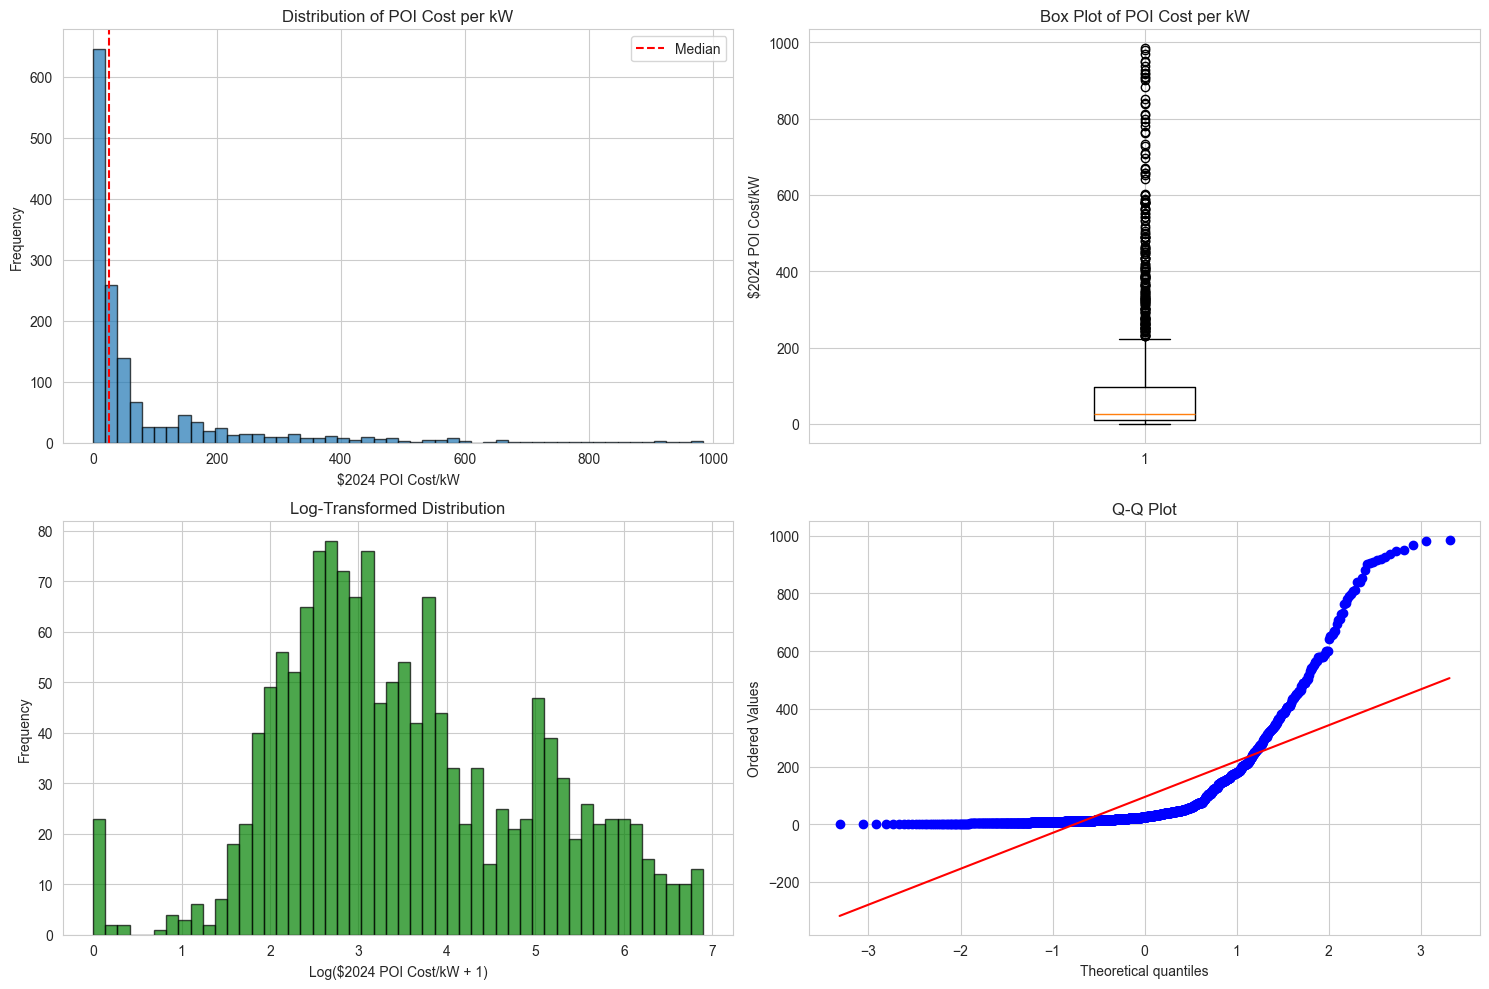

POI Cost Statistics:
count    1507.000000
mean       94.302960
std       161.523785
min         0.000000
25%        11.560000
50%        25.010000
75%        96.910000
max       984.550000
Name: $2024 POI Cost/kW, dtype: float64

Skewness: 2.89
Kurtosis: 9.21


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

df = cost_cleaned.copy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df['$2024 POI Cost/kW'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('$2024 POI Cost/kW')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of POI Cost per kW')
axes[0, 0].axvline(df['$2024 POI Cost/kW'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(df['$2024 POI Cost/kW'].dropna(), vert=True)
axes[0, 1].set_ylabel('$2024 POI Cost/kW')
axes[0, 1].set_title('Box Plot of POI Cost per kW')

# Log-transformed distribution
log_poi_cost = np.log1p(df['$2024 POI Cost/kW'])
axes[1, 0].hist(log_poi_cost, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Log($2024 POI Cost/kW + 1)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Log-Transformed Distribution')

# Q-Q plot quantiles v. theoretical quantiles
stats.probplot(df['$2024 POI Cost/kW'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

print(f"POI Cost Statistics:")
print(df['$2024 POI Cost/kW'].describe())
print(f"\nSkewness: {df['$2024 POI Cost/kW'].skew():.2f}")
print(f"Kurtosis: {df['$2024 POI Cost/kW'].kurtosis():.2f}")



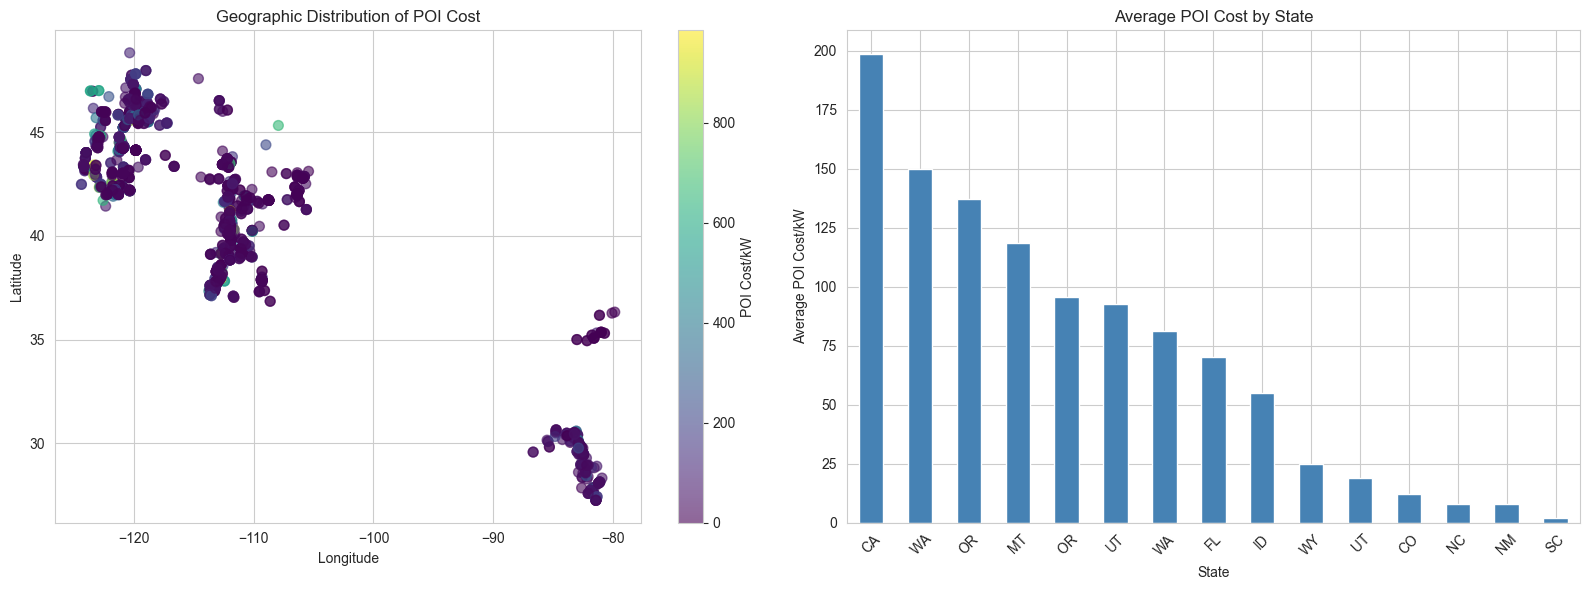

In [13]:
##Geographic Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot with lat/lon
scatter = axes[0].scatter(df['Longitude of POI'], df['Latitude of POI'], 
                          c=df['$2024 POI Cost/kW'], cmap='viridis', 
                          alpha=0.6, s=50)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Geographic Distribution of POI Cost')
plt.colorbar(scatter, ax=axes[0], label='POI Cost/kW')

# State-level average costs
state_costs = df.groupby('State')['$2024 POI Cost/kW'].agg(['mean', 'count']).sort_values('mean', ascending=False)
state_costs['mean'].plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_xlabel('State')
axes[1].set_ylabel('Average POI Cost/kW')
axes[1].set_title('Average POI Cost by State')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


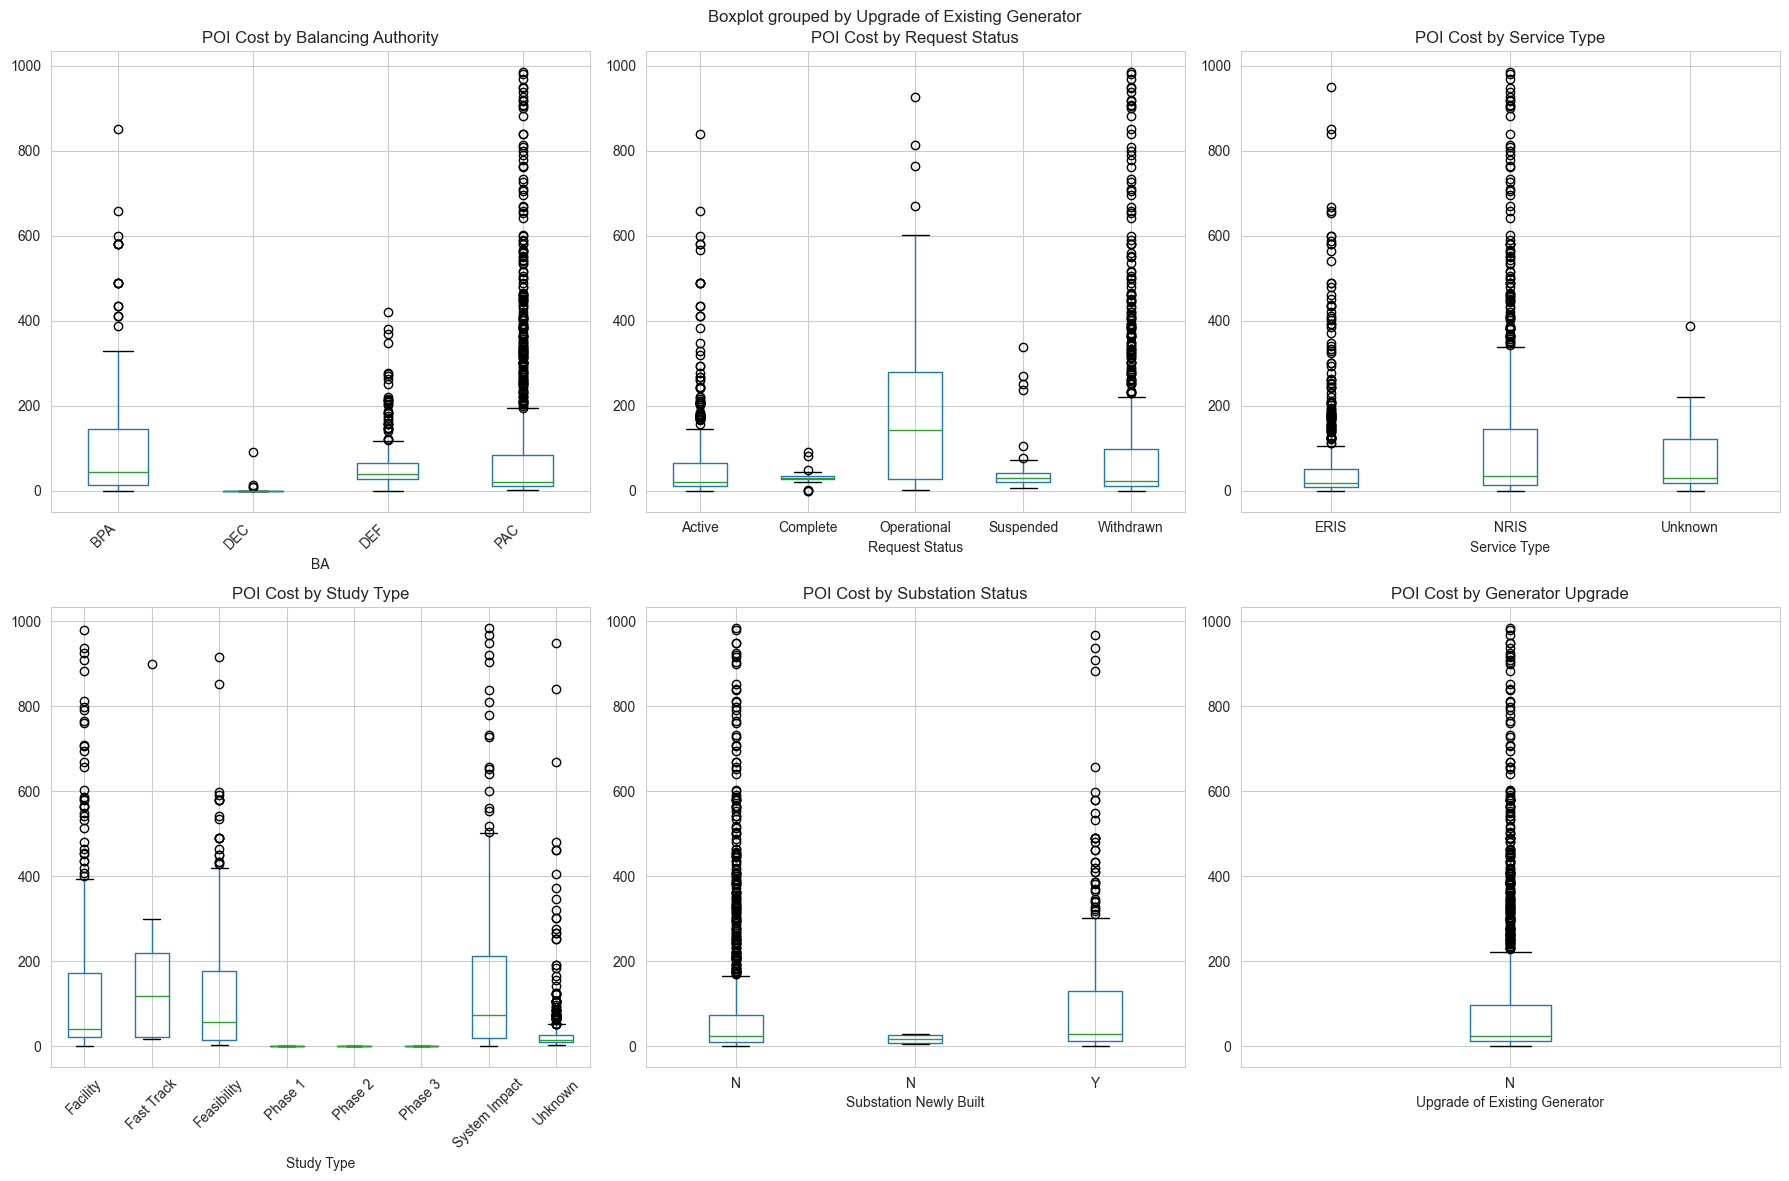

In [14]:
## Categorical Features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Balancing Authority
df.boxplot(column='$2024 POI Cost/kW', by='BA', ax=axes[0, 0], rot=90)
axes[0, 0].set_title('POI Cost by Balancing Authority')
axes[0, 0].set_xlabel('BA')
plt.sca(axes[0, 0])
plt.xticks(rotation=45, ha='right')

# Request Status
df.boxplot(column='$2024 POI Cost/kW', by='Request Status', ax=axes[0, 1])
axes[0, 1].set_title('POI Cost by Request Status')
axes[0, 1].set_xlabel('Request Status')

# Service Type
df.boxplot(column='$2024 POI Cost/kW', by='Service Type', ax=axes[0, 2])
axes[0, 2].set_title('POI Cost by Service Type')
axes[0, 2].set_xlabel('Service Type')

# Study Type
df.boxplot(column='$2024 POI Cost/kW', by='Study Type', ax=axes[1, 0], rot=45)
axes[1, 0].set_title('POI Cost by Study Type')
axes[1, 0].set_xlabel('Study Type')

# Substation Newly Built
df.boxplot(column='$2024 POI Cost/kW', by='Substation Newly Built', ax=axes[1, 1])
axes[1, 1].set_title('POI Cost by Substation Status')
axes[1, 1].set_xlabel('Substation Newly Built')

# Upgrade of Existing Generator
df.boxplot(column='$2024 POI Cost/kW', by='Upgrade of Existing Generator', ax=axes[1, 2])
axes[1, 2].set_title('POI Cost by Generator Upgrade')
axes[1, 2].set_xlabel('Upgrade of Existing Generator')

plt.tight_layout()
plt.show()


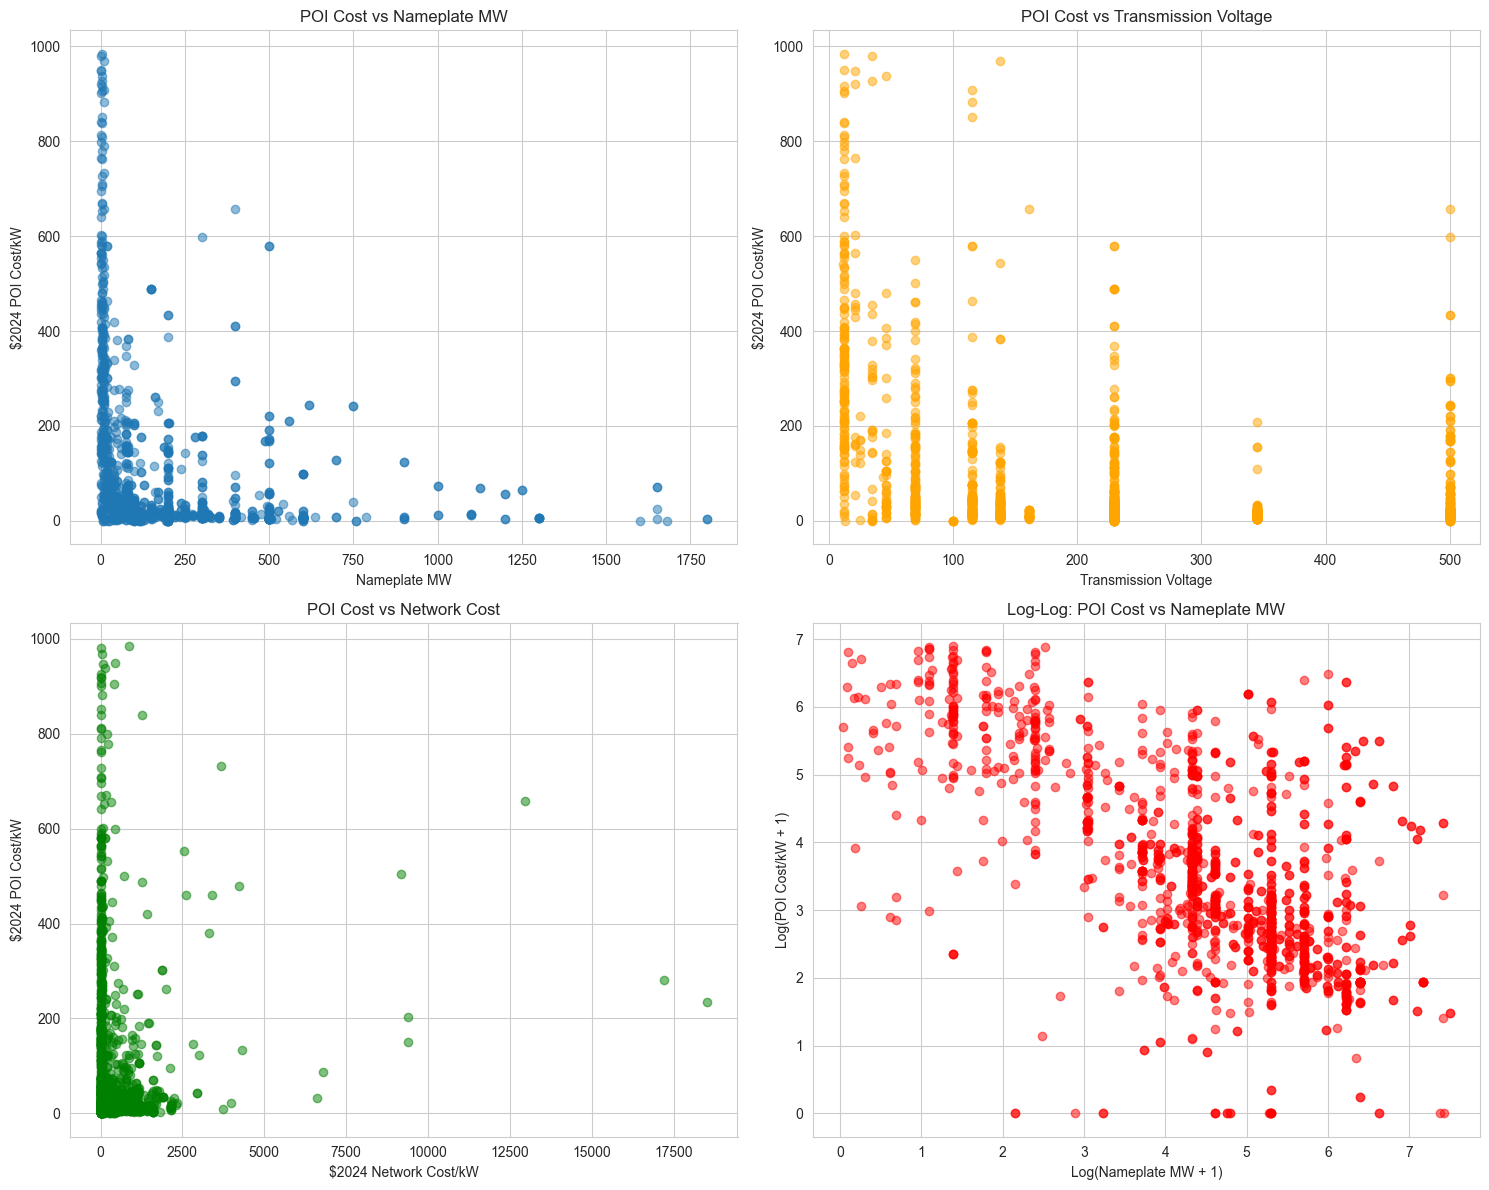

In [15]:
##Numerical Features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# POI Cost vs Nameplate MW
axes[0, 0].scatter(df['Nameplate MW'], df['$2024 POI Cost/kW'], alpha=0.5)
axes[0, 0].set_xlabel('Nameplate MW')
axes[0, 0].set_ylabel('$2024 POI Cost/kW')
axes[0, 0].set_title('POI Cost vs Nameplate MW')

# POI Cost vs Transmission Voltage
axes[0, 1].scatter(df['Transmission Voltage'], df['$2024 POI Cost/kW'], alpha=0.5, color='orange')
axes[0, 1].set_xlabel('Transmission Voltage')
axes[0, 1].set_ylabel('$2024 POI Cost/kW')
axes[0, 1].set_title('POI Cost vs Transmission Voltage')

# POI Cost vs Network Cost
axes[1, 0].scatter(df['$2024 Network Cost/kW'], df['$2024 POI Cost/kW'], alpha=0.5, color='green')
axes[1, 0].set_xlabel('$2024 Network Cost/kW')
axes[1, 0].set_ylabel('$2024 POI Cost/kW')
axes[1, 0].set_title('POI Cost vs Network Cost')

# Log-log plot for Nameplate MW (often shows clearer relationship)
axes[1, 1].scatter(np.log1p(df['Nameplate MW']), np.log1p(df['$2024 POI Cost/kW']), alpha=0.5, color='red')
axes[1, 1].set_xlabel('Log(Nameplate MW + 1)')
axes[1, 1].set_ylabel('Log(POI Cost/kW + 1)')
axes[1, 1].set_title('Log-Log: POI Cost vs Nameplate MW')

plt.tight_layout()
plt.show()


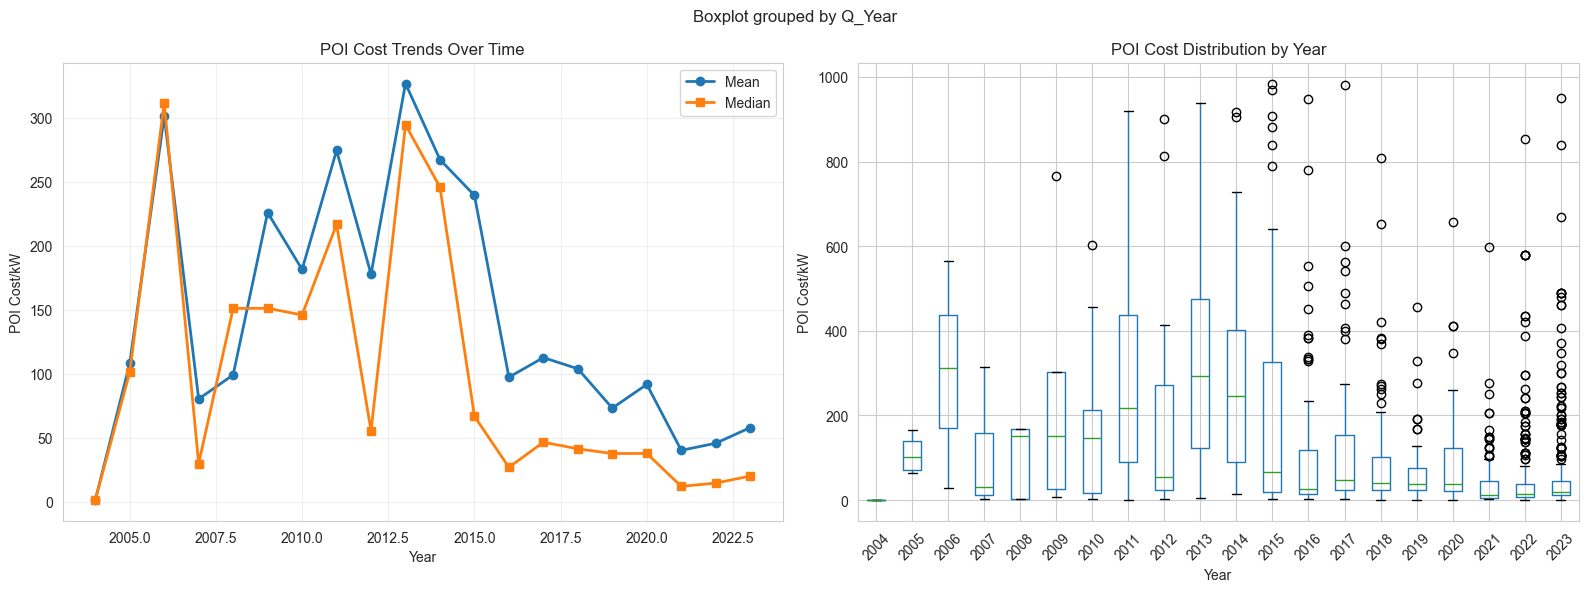

In [16]:
#Graphs Over Time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create study year if not exists
df['S_Year'] = df['Q_Year']  

# Time series by year
yearly_stats = df.groupby('Q_Year')['$2024 POI Cost/kW'].agg(['mean', 'median', 'count'])
axes[0].plot(yearly_stats.index, yearly_stats['mean'], marker='o', label='Mean', linewidth=2)
axes[0].plot(yearly_stats.index, yearly_stats['median'], marker='s', label='Median', linewidth=2)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('POI Cost/kW')
axes[0].set_title('POI Cost Trends Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by year
df.boxplot(column='$2024 POI Cost/kW', by='Q_Year', ax=axes[1])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('POI Cost/kW')
axes[1].set_title('POI Cost Distribution by Year')
plt.sca(axes[1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



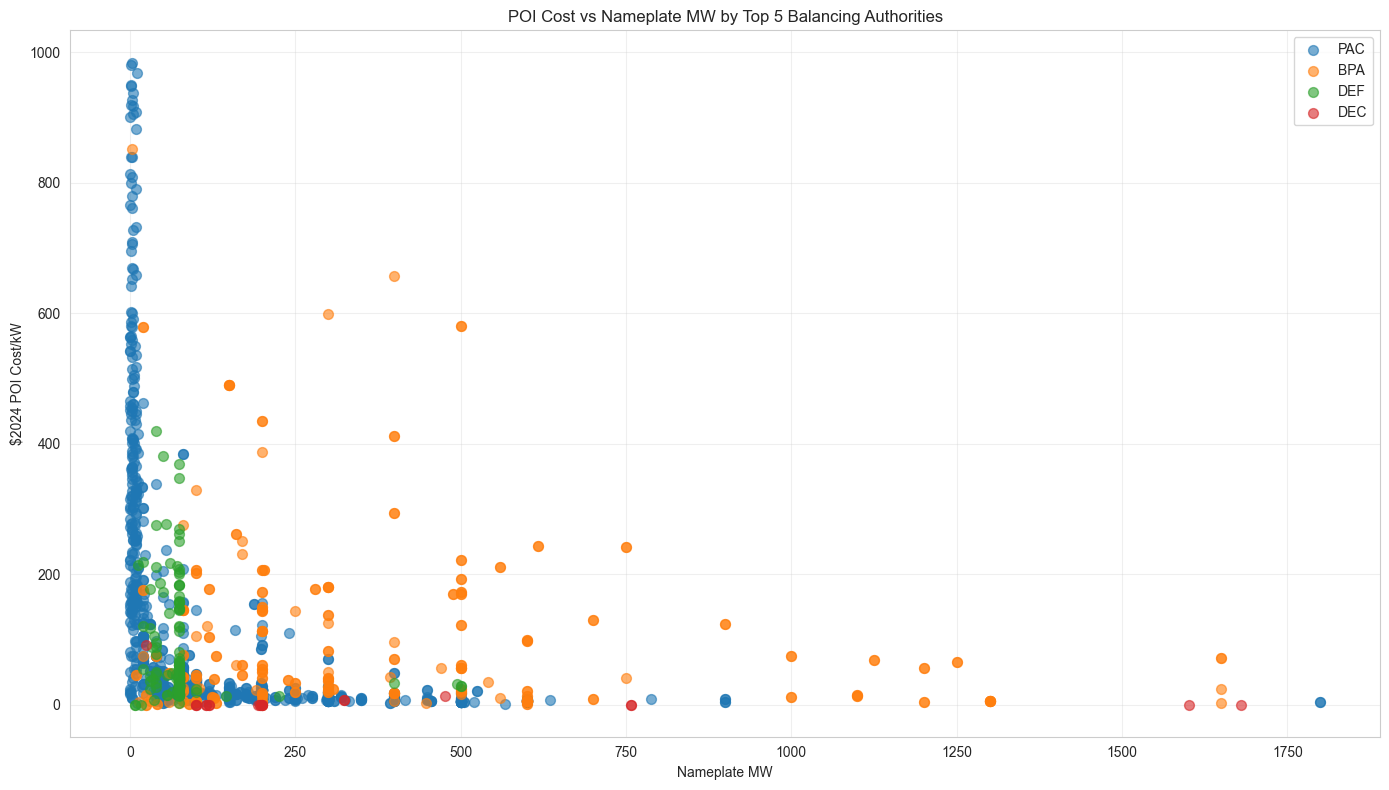

In [17]:
## Multivariable Plots

# POI Cost vs Nameplate MW, colored by BA (top BAs only)
top_bas = df['BA'].value_counts().head(5).index
df_top = df[df['BA'].isin(top_bas)]

plt.figure(figsize=(14, 8))
for ba in top_bas:
    subset = df_top[df_top['BA'] == ba]
    plt.scatter(subset['Nameplate MW'], subset['$2024 POI Cost/kW'], 
                label=ba, alpha=0.6, s=50)
plt.xlabel('Nameplate MW')
plt.ylabel('$2024 POI Cost/kW')
plt.title('POI Cost vs Nameplate MW by Top 5 Balancing Authorities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


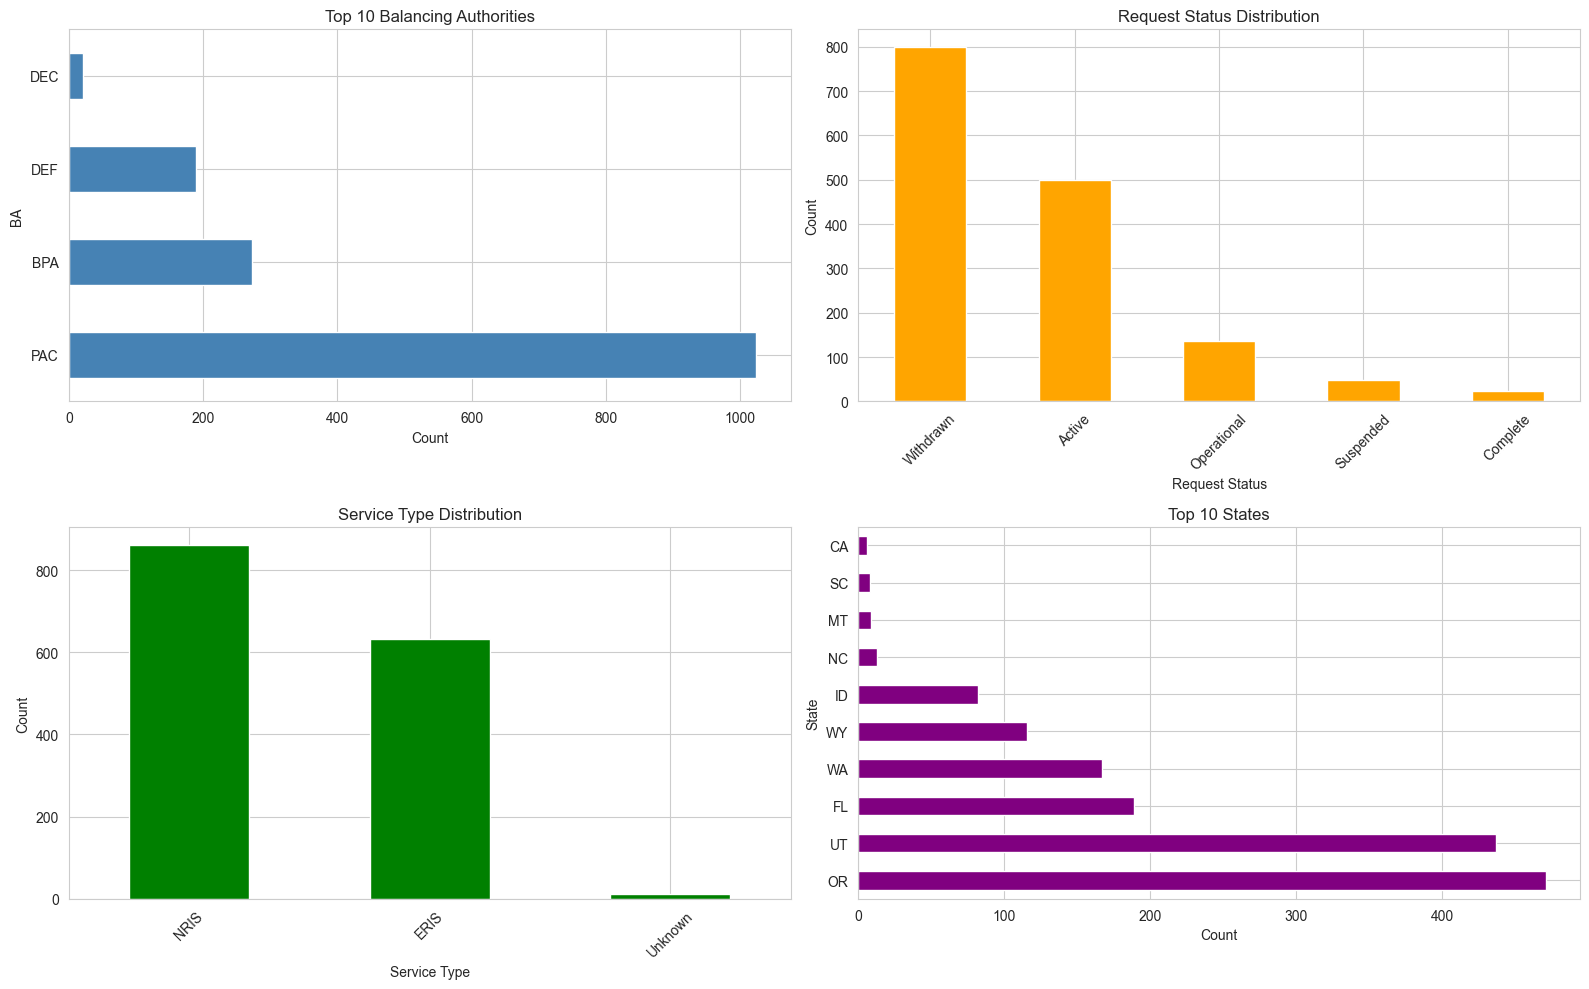

In [18]:
## Categorical Feature Counts
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# BA distribution
ba_counts = df['BA'].value_counts().head(10)
ba_counts.plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_title('Top 10 Balancing Authorities')

# Request Status
df['Request Status'].value_counts().plot(kind='bar', ax=axes[0, 1], color='orange')
axes[0, 1].set_xlabel('Request Status')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Request Status Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)

# Service Type
df['Service Type'].value_counts().plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_xlabel('Service Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Service Type Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)

# State distribution
state_counts = df['State'].value_counts().head(10)
state_counts.plot(kind='barh', ax=axes[1, 1], color='purple')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_title('Top 10 States')

plt.tight_layout()
plt.show()


## Models

In [19]:
#Feature Engineering
df = cost_cleaned.copy() #im getting lazy rewriting cost_cleaned lol
num_features = ['Latitude of POI', 'Longitude of POI', 'Study Year', 'Transmission Voltage', 'Nameplate MW', '$2024 Network Cost/kW', 'S_Month', 'S_Day', 'Q_Year', 'Q_Month', 'Q_Day']
cat_features = ['Balancing Authority', 'BA', 'State', 'County', 'Upgrade of Existing Generator',  'Substation Newly Built', 'Study Type', 'Restudy', 'Revision of Study', 'Fuel', 'Request Status', 'Service Type']
all_features = num_features + cat_features

target = "$2024 POI Cost/kW"


X = cost_cleaned.drop(columns=[target])
y = cost_cleaned[target]

y_log = np.log1p(y) #for ridge models as EDA shows log-like curve in Q-Q

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)
_, _, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=67)



In [20]:
## Random Forest
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", "passthrough", num_features)
])

rf_model = Pipeline([
    ("preprocess", preprocess),
    ("ridge", RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1
))
])

rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

print(f"\nRandom Forest Results:")
print(f"Train RMSE: ${rf_train_rmse:.2f}/kW | Test RMSE: ${rf_test_rmse:.2f}/kW")
print(f"Train MAE:  ${rf_train_mae:.2f}/kW | Test MAE:  ${rf_test_mae:.2f}/kW")
print(f"Train R²:   {rf_train_r2:.4f}     | Test R²:   {rf_test_r2:.4f}")


Python(96266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Random Forest Results:
Train RMSE: $49.34/kW | Test RMSE: $88.26/kW
Train MAE:  $22.47/kW | Test MAE:  $43.28/kW
Train R²:   0.9077     | Test R²:   0.6869


In [21]:
##Ridge Regression with Log Transformation
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", "passthrough", num_features)
])

ridge_model = Pipeline([
    ("preprocess", preprocess),
    ("ridge", Ridge(alpha=100, solver='lsqr'))
])


ridge_model.fit(X_train, y_train_log)

ridge_train_pred_log = ridge_model.predict(X_train)
ridge_test_pred_log = ridge_model.predict(X_test)
ridge_train_pred = np.expm1(ridge_train_pred_log)
ridge_test_pred = np.expm1(ridge_test_pred_log)

ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_train_pred))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_pred))
ridge_train_mae = mean_absolute_error(y_train, ridge_train_pred)
ridge_test_mae = mean_absolute_error(y_test, ridge_test_pred)
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)

print(f"\nRidge Regression Results:")
print(f"Train RMSE: ${ridge_train_rmse:.2f}/kW | Test RMSE: ${ridge_test_rmse:.2f}/kW")
print(f"Train MAE:  ${ridge_train_mae:.2f}/kW | Test MAE:  ${ridge_test_mae:.2f}/kW")
print(f"Train R²:   {ridge_train_r2:.4f}     | Test R²:   {ridge_test_r2:.4f}")



Ridge Regression Results:
Train RMSE: $148.62/kW | Test RMSE: $145.73/kW
Train MAE:  $68.99/kW | Test MAE:  $68.89/kW
Train R²:   0.1624     | Test R²:   0.1463


In [22]:
##Gradient Boosting
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", "passthrough", num_features)
])

gb_model = Pipeline([
    ("preprocess", preprocess),
    ("ridge", GradientBoostingRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8
))
])

gb_model.fit(X_train, y_train)

gb_train_pred = gb_model.predict(X_train)
gb_test_pred = gb_model.predict(X_test)

gb_train_rmse = np.sqrt(mean_squared_error(y_train, gb_train_pred))
gb_test_rmse = np.sqrt(mean_squared_error(y_test, gb_test_pred))
gb_train_mae = mean_absolute_error(y_train, gb_train_pred)
gb_test_mae = mean_absolute_error(y_test, gb_test_pred)
gb_train_r2 = r2_score(y_train, gb_train_pred)
gb_test_r2 = r2_score(y_test, gb_test_pred)

print(f"\nGradient Boost Results:")
print(f"Train RMSE: ${gb_train_rmse:.2f}/kW | Test RMSE: ${gb_test_rmse:.2f}/kW")
print(f"Train MAE:  ${gb_train_mae:.2f}/kW | Test MAE:  ${gb_test_mae:.2f}/kW")
print(f"Train R²:   {gb_train_r2:.4f}     | Test R²:   {gb_test_r2:.4f}")



Gradient Boost Results:
Train RMSE: $5.83/kW | Test RMSE: $87.50/kW
Train MAE:  $2.27/kW | Test MAE:  $39.55/kW
Train R²:   0.9987     | Test R²:   0.6922


In [23]:
#used code from online to help make function
def get_pipeline_feature_importances(pipeline):
    model = pipeline.named_steps['ridge']
    
    preprocessor = pipeline.named_steps[
        [name for name, step in pipeline.named_steps.items() if isinstance(step, ColumnTransformer)][0]
    ]
    
    processed_feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder' and transformer == 'passthrough':
            processed_feature_names.extend(cols)
        elif hasattr(transformer, 'get_feature_names_out'):
            processed_feature_names.extend(transformer.get_feature_names_out(cols))
        else:
            processed_feature_names.extend(cols)
    
    if len(processed_feature_names) != len(model.feature_importances_):
        raise ValueError("Number of processed features does not match feature_importances_.")
    
    importance_df = pd.DataFrame({
        "feature": processed_feature_names,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)
    
    return importance_df[:15]


In [274]:
gb_feature_importance = get_pipeline_feature_importances(gb_model)
rf_feature_importance = get_pipeline_feature_importances(rf_model)
print(gb_feature_importance)
print(rf_feature_importance)



                      feature  importance
194              Nameplate MW    0.382698
195     $2024 Network Cost/kW    0.074681
190           Latitude of POI    0.051104
191          Longitude of POI    0.039179
196                   S_Month    0.035794
154  Substation Newly Built_Y    0.033272
197                     S_Day    0.029392
193      Transmission Voltage    0.028505
199                   Q_Month    0.025339
200                     Q_Day    0.021962
192                Study Year    0.021137
157    Study Type_Feasibility    0.019312
152  Substation Newly Built_N    0.019142
162        Study Type_Unknown    0.016929
198                    Q_Year    0.016516
                      feature  importance
194              Nameplate MW    0.451744
195     $2024 Network Cost/kW    0.073394
190           Latitude of POI    0.036245
152  Substation Newly Built_N    0.034814
197                     S_Day    0.031341
191          Longitude of POI    0.031216
196                   S_Month    0

## Model Comparisons and Visualizations

In [ ]:
##Comparison

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boost', 'Ridge Regression'],
    'Test RMSE': [rf_test_rmse, gb_test_rmse, ridge_test_rmse],
    'Test MAE': [rf_test_mae, gb_test_mae, ridge_test_mae],
    'Test R²': [rf_test_r2, gb_test_r2, ridge_test_r2],
    'Train RMSE': [rf_train_rmse, gb_train_rmse, ridge_train_rmse],
    'Train R²': [rf_train_r2, gb_train_r2, ridge_train_r2]
})

comparison_df['Overfit Gap (R²)'] = comparison_df['Train R²'] - comparison_df['Test R²']
comparison_df = comparison_df.sort_values('Test RMSE')

print("\nModel Performance Comparison (sorted by Test RMSE):")
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
print(f"\n  Best Model: {best_model_name}")
print(f"   Test RMSE: ${comparison_df.iloc[0]['Test RMSE']:.2f}/kW")
print(f"   Test R²: {comparison_df.iloc[0]['Test R²']:.4f}")




Model Performance Comparison (sorted by Test RMSE):
           Model  Test RMSE  Test MAE  Test R²  Train RMSE  Train R²  Overfit Gap (R²)
  Gradient Boost  52.797285 25.850502 0.660489    5.200555  0.996393          0.335904
   Random Forest  54.153253 29.552201 0.642826   25.582615  0.912713          0.269888
Ridge Regression  85.478703 46.281119 0.110088   78.971056  0.168249          0.058161

  Best Model: Gradient Boost
   Test RMSE: $52.80/kW
   Test R²: 0.6605


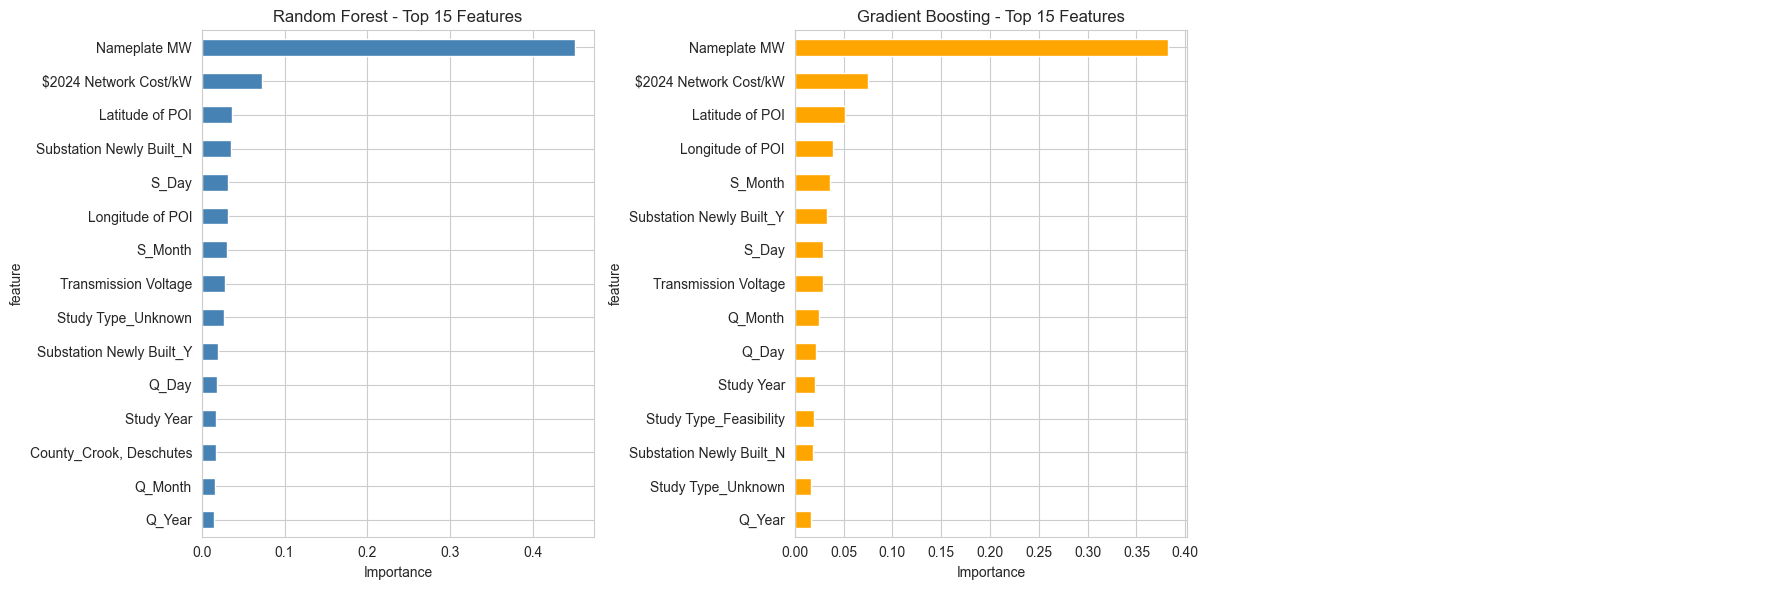

In [269]:
##Feature Importance Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest
rf_feature_importance.head(15).plot(
    x='feature', y='importance', kind='barh',
    ax=axes[0], color='steelblue', legend=False
)
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 15 Features')
axes[0].invert_yaxis()  # So the most important is on top

# Gradient Boosting
gb_feature_importance.head(15).plot(
    x='feature', y='importance', kind='barh',
    ax=axes[1], color='orange', legend=False
)
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting - Top 15 Features')
axes[1].invert_yaxis()

# placeholder for a third model
axes[2].axis('off') 

plt.tight_layout()
plt.show()


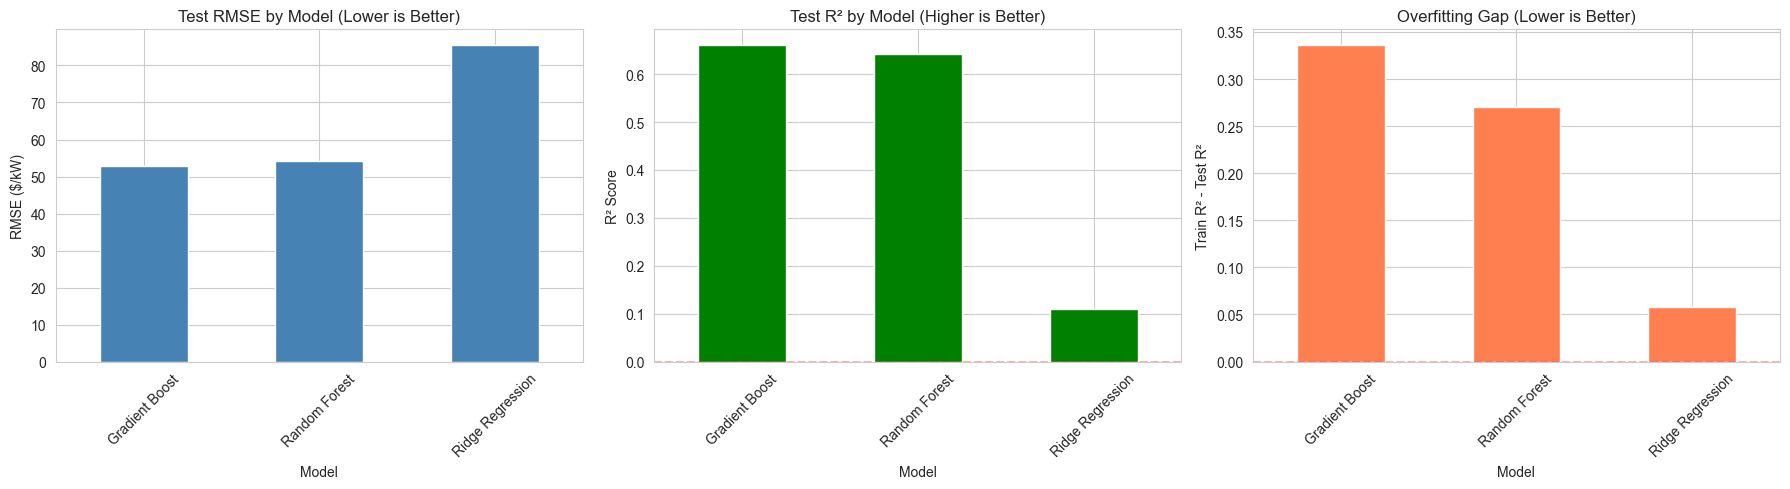

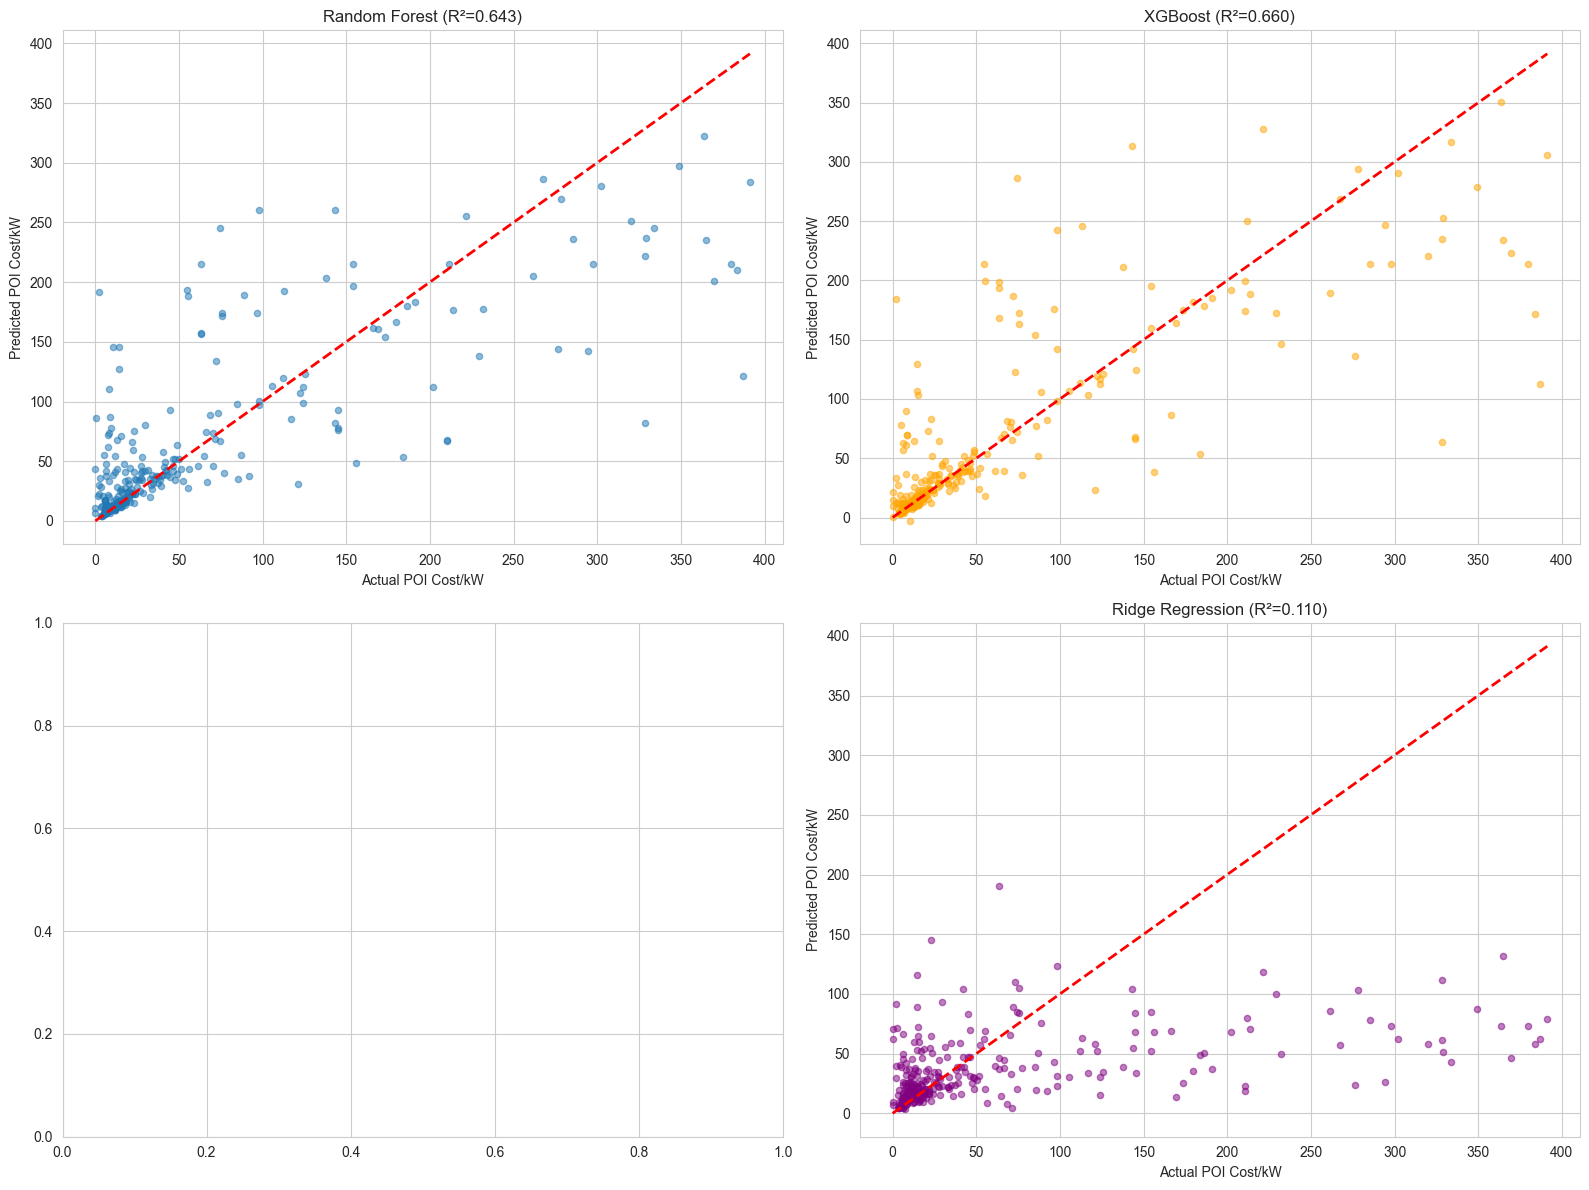

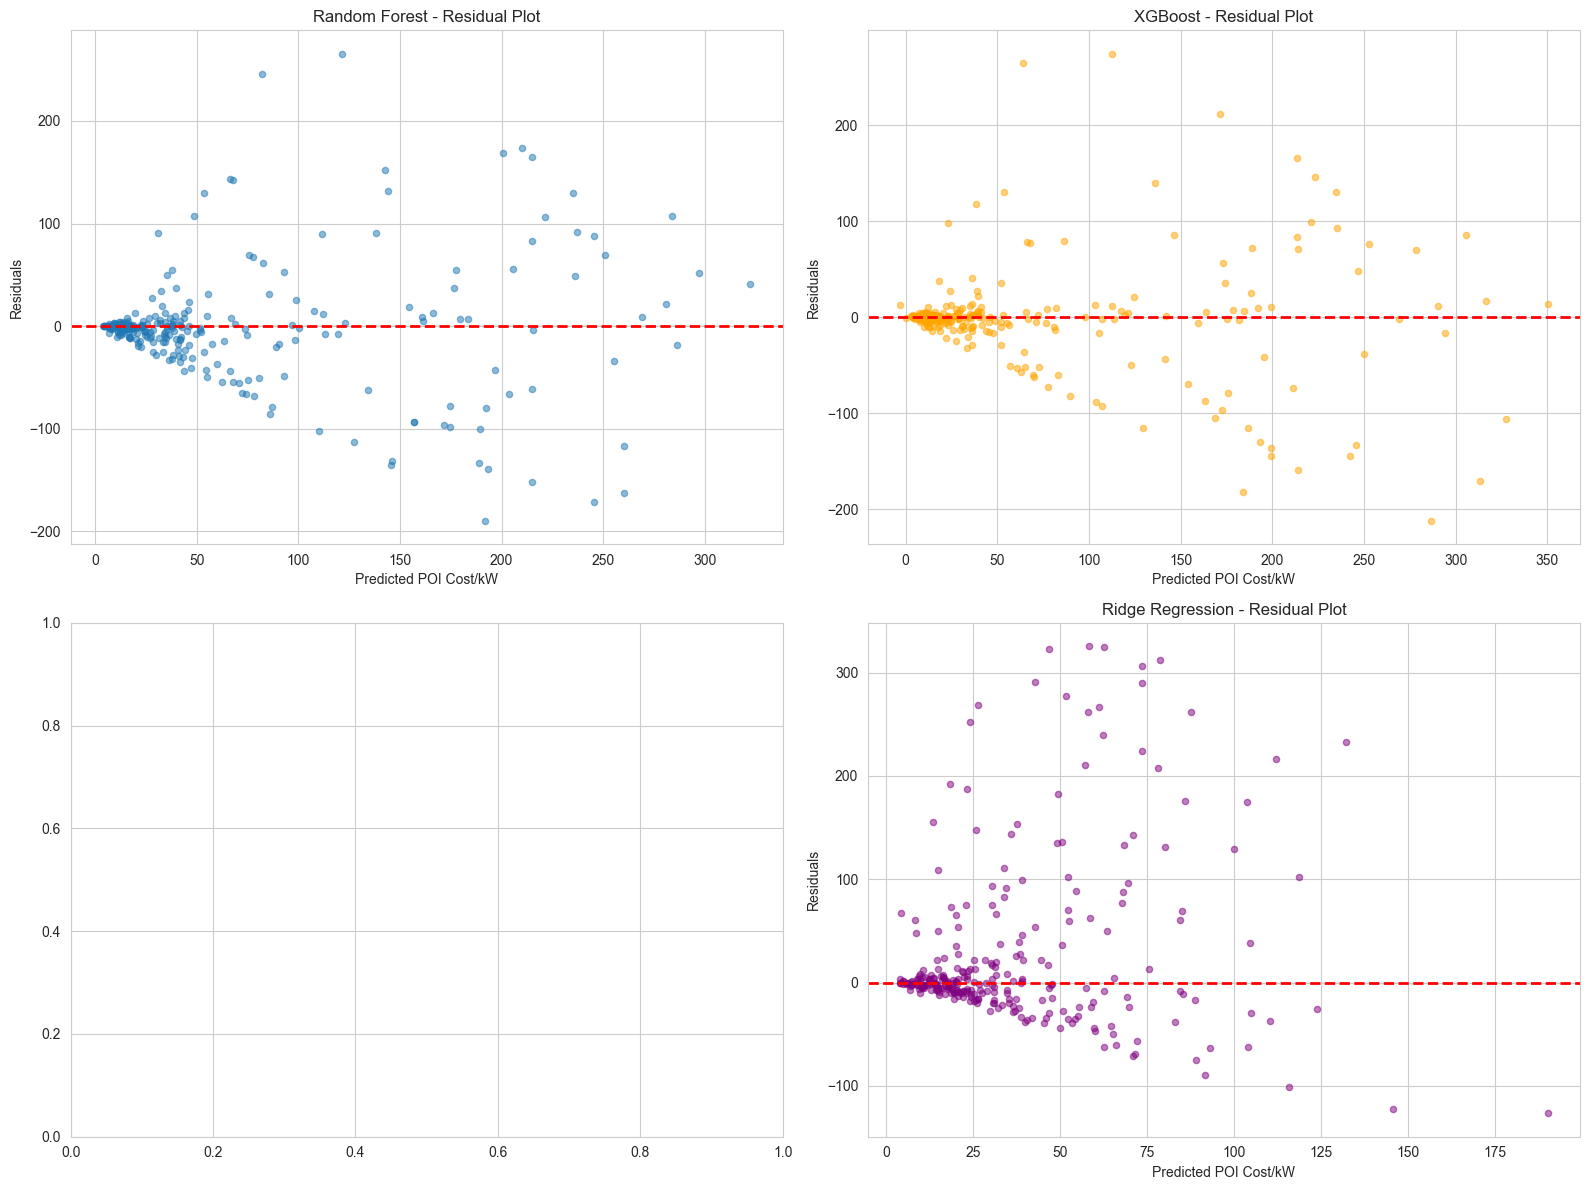

In [ ]:
##Model Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

comparison_df.plot(x='Model', y='Test RMSE', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_ylabel('RMSE ($/kW)')
axes[0].set_title('Test RMSE by Model (Lower is Better)')
axes[0].tick_params(axis='x', rotation=45)

comparison_df.plot(x='Model', y='Test R²', kind='bar', ax=axes[1], color='green', legend=False)
axes[1].set_ylabel('R² Score')
axes[1].set_title('Test R² by Model (Higher is Better)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.3)

comparison_df.plot(x='Model', y='Overfit Gap (R²)', kind='bar', ax=axes[2], color='coral', legend=False)
axes[2].set_ylabel('Train R² - Test R²')
axes[2].set_title('Overfitting Gap (Lower is Better)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.3)

print("Model Comparison Bar Chart")
plt.tight_layout()
plt.show()


In [ ]:
##Actual vs Predicted (Best Model)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Random Forest
axes[0, 0].scatter(y_test, rf_test_pred, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual POI Cost/kW')
axes[0, 0].set_ylabel('Predicted POI Cost/kW')
axes[0, 0].set_title(f'Random Forest (R²={rf_test_r2:.3f})')

# Gradient Boost
axes[0, 1].scatter(y_test, gb_test_pred, alpha=0.5, s=20, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual POI Cost/kW')
axes[0, 1].set_ylabel('Predicted POI Cost/kW')
axes[0, 1].set_title(f'XGBoost (R²={gb_test_r2:.3f})')

# Ridge
axes[1, 1].scatter(y_test, ridge_test_pred, alpha=0.5, s=20, color='purple')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual POI Cost/kW')
axes[1, 1].set_ylabel('Predicted POI Cost/kW')
axes[1, 1].set_title(f'Ridge Regression (R²={ridge_test_r2:.3f})')

print("Actual v. Predicted Results")
plt.tight_layout()
plt.show()


Residual Analysis


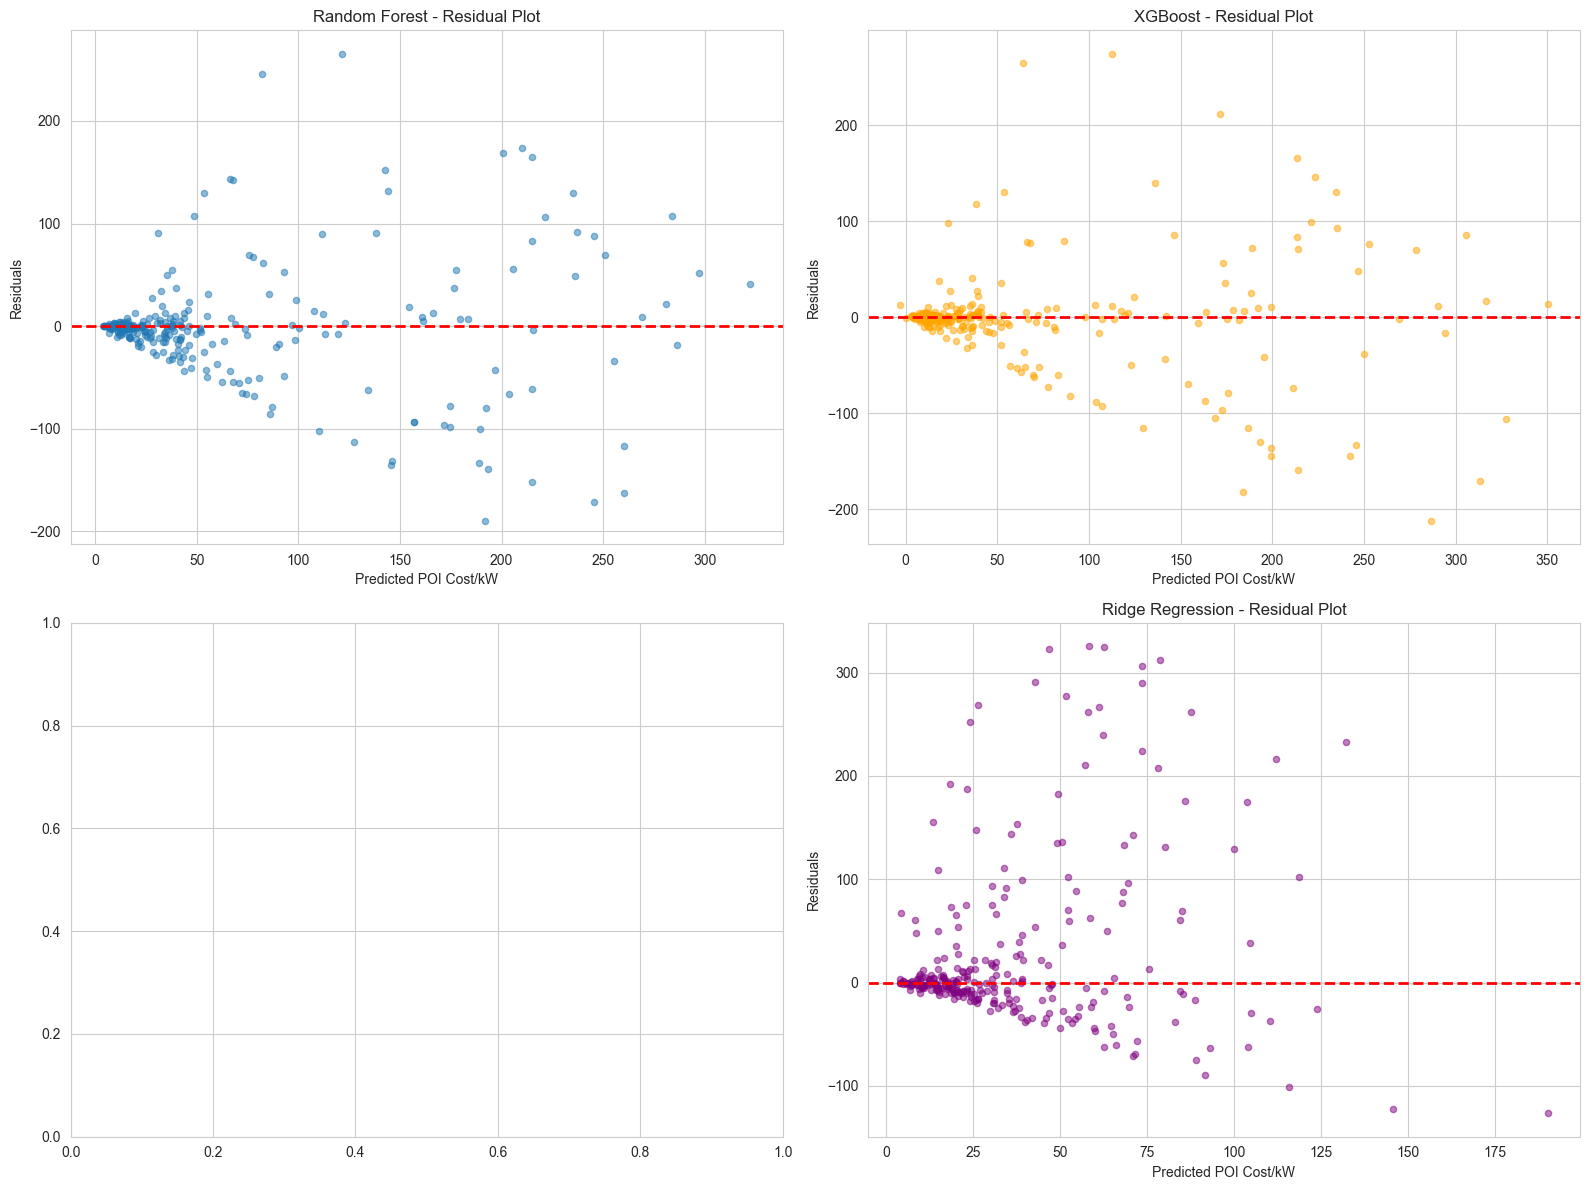

In [272]:

## Residual Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Random Forest 
rf_residuals = y_test - rf_test_pred
axes[0, 0].scatter(rf_test_pred, rf_residuals, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted POI Cost/kW')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Random Forest - Residual Plot')

# Gradient Boost 
xgb_residuals = y_test - gb_test_pred
axes[0, 1].scatter(gb_test_pred, xgb_residuals, alpha=0.5, s=20, color='orange')
axes[0, 1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted POI Cost/kW')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('XGBoost - Residual Plot')


# Ridge 
ridge_residuals = y_test - ridge_test_pred
axes[1, 1].scatter(ridge_test_pred, ridge_residuals, alpha=0.5, s=20, color='purple')
axes[1, 1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted POI Cost/kW')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Ridge Regression - Residual Plot')

print("Residual Analysis")
plt.tight_layout()
plt.show()


## Cross Validation and maybe Bootstrapping Models (TO DO)

In [27]:
models = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [5, 10, None, 15, 3, 20],
            "min_samples_split": [2, 5, 6, 9],
            "min_samples_leaf": [1, 2, 7, 4],
        }
    },
    "RidgeRegression": {
        "model": Ridge(),
        "params": {
            "alpha": [0.01, 0.1, 1, 10, 20, 100, 200],
            "solver": ["auto", "lsqr", "sparse_cg", "sag", "lbfgs"],  # remove 'svd'
        }
    
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.07, 0.08, 0.1],
            "max_depth": [4, 5, 7, 8, 9],
            "subsample": [0.8, 1.0, 0.5, 0.9]
        }
    }
}

#OHE

cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", "passthrough", num_features)
])

#models

best_models = {}

for name, m in models.items():
    print(f"Running GridSearchCV for {name}...")
    
    pipeline = Pipeline([
        ("preprocess", preprocess),
        ("model", m["model"])
    ])
    
    grid = GridSearchCV(
        pipeline,
        param_grid={"model__" + k: v for k, v in m["params"].items()},
        cv=5,
        scoring="neg_mean_absolute_error",   # for the regression metric
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    best_models[name] = grid

    y_pred = grid.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Best RMSE for {name}: {rmse:.4f}")
    print(f"Best R² for {name}: {r2:.4f}")
    print(f"Best parameters: {grid.best_params_}\n")


Running GridSearchCV for RandomForest...


Python(96864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best RMSE for RandomForest: 87.0553
Best R² for RandomForest: 0.6954
Best parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}

Running GridSearchCV for RidgeRegression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
35 fits failed out of a total of 175.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Best RMSE for RidgeRegression: 135.6263
Best R² for RidgeRegression: 0.2606
Best parameters: {'model__alpha': 20, 'model__solver': 'auto'}

Running GridSearchCV for GradientBoosting...
Best RMSE for GradientBoosting: 88.3302
Best R² for GradientBoosting: 0.6864
Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 9, 'model__n_estimators': 300, 'model__subsample': 0.9}

